## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

This notebook will be divided in several blocks

+ Data load
+ Data cleaning
+ Feature engineering
+ Data visualization
+ Model training
+ Model selection
+ Model tuning
+ Save results


In [1]:
#Import general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Import SageMaker libraries
import boto3
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

from sagemaker.content_types import CONTENT_TYPE_CSV

### 2.1 Data load

In [2]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='sagemaker-eu-west-1-848439228145'

In [3]:
import re 

# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

def filter_csv(string):
    return re.search(r'.csv', string)


files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
filtered_list = list(filter(filter_csv, files))
    
    
# print csv objects in in S3 bucket  
print(filtered_list)

['Capstone/Udacity_AZDIAS_052018.csv', 'Capstone/Udacity_CUSTOMERS_052018.csv', 'Capstone/Udacity_MAILOUT_052018_TEST.csv', 'Capstone/Udacity_MAILOUT_052018_TRAIN.csv', 'arvato/azdias.csv', 'arvato/customers.csv', 'arvato/transform/pca/transform/test/azdias.csv.out', 'arvato/transform/pca/transform/test/customers.csv.out', 'mailout-xgboost/mailout_test.csv', 'mailout-xgboost/mailout_train.csv', 'mailout-xgboost/mailout_validation.csv', 'mailout/transform/test/mailout_test.csv.out', 'test/customers.csv.out', 'xgboost-200512-2100-006-5d9003f4-2020-05-12-21-13-29-318/mailout_test.csv.out', 'xgboost-200513-1550-009-510b69c6-2020-05-13-16-00-48-200/mailout_test.csv.out', 'xgboost-200513-2107-008-571099bb-2020-05-13-21-17-53-739/mailout_test.csv.out', 'xgboost-200513-2210-004-d4b243f8-2020-05-13-22-22-41-620/mailout_test.csv.out']


In [4]:
def load_dataframe_from_s3(s3_client, bucket, name):
    data_object = s3_client.get_object(Bucket=bucket, Key=name)
    data_body = data_object["Body"].read()
    data_stream = io.BytesIO(data_body)
    
    return pd.read_csv(data_stream, header=0, delimiter=",") 

In [5]:
mailout_train_df = None
mailout_train_df = load_dataframe_from_s3(s3_client, bucket_name, filtered_list[3])
mailout_train_df.head()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Separate features from target

In [6]:
mailout_train_df_target = mailout_train_df['RESPONSE']

In [7]:
mailout_train_df.drop('RESPONSE', axis = 1, inplace = True)

In [8]:
mailout_test_df = None
mailout_test_df = load_dataframe_from_s3(s3_client, bucket_name, filtered_list[2])
mailout_test_df.head()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


### 2.1 Data cleaning

Find rows with more that 25% missing values

In [9]:
rows = mailout_train_df.shape[0]
missing_mailout_train = mailout_train_df.isnull().sum().sort_values(ascending = False).divide(other = (rows/100))

display(missing_mailout_train.loc[missing_mailout_train > 25])

ALTER_KIND4     99.904567
ALTER_KIND3     99.594991
ALTER_KIND2     98.240305
ALTER_KIND1     95.372655
KK_KUNDENTYP    58.926493
EXTSEL992       37.121177
dtype: float64

In [10]:
rows = mailout_test_df.shape[0]
missing_mailout_test = mailout_test_df.isnull().sum().sort_values(ascending = False).divide(other = (rows/100))

display(missing_mailout_test.loc[missing_mailout_test > 25])

ALTER_KIND4     99.908949
ALTER_KIND3     99.530736
ALTER_KIND2     98.220998
ALTER_KIND1     95.300353
KK_KUNDENTYP    58.447926
EXTSEL992       36.908458
dtype: float64

#### 2.1.1 Drop columns with more than a 60% of missing values

In [11]:
#make a dict with the names of the columns and then drop this columns from dataframe
def dropMissingColumns(df, threshold = 20):
    missing_percentages = df.isnull().sum().sort_values(ascending = False).divide(other = (rows/100))
    drop_columns = missing_percentages[missing_percentages > threshold]
    df.drop(columns = list(drop_columns.index), axis = 1, inplace = True)

In [12]:
dropMissingColumns(mailout_train_df, threshold = 60)
mailout_train_df.shape

(42962, 363)

In [13]:
dropMissingColumns(mailout_test_df, threshold = 60)
mailout_test_df.shape

(42833, 363)

#### 2.1.2 Drop low dispersion cols

In [14]:
def getVariances(df):
    df_description = df.describe()
    std_df = df_description.loc[['std']].values.reshape(df_description.shape[1],)
    return pd.Series(std_df, index =df_description.columns) 

def dropLowVarianceCols(df, threshold = 0.5):
    std_serie = getVariances(df)

    drop_lowdispersion_cols = std_serie[std_serie < threshold]
    print("Dropping columns: ",drop_lowdispersion_cols)
    df.drop(columns = list(drop_lowdispersion_cols.index), axis = 1, inplace = True)
    
    return drop_lowdispersion_cols.index

In [15]:
mailout_train_drops = dropLowVarianceCols(mailout_train_df, threshold = 0.5)

Dropping columns:  ANZ_HH_TITEL                 0.380335
ANZ_KINDER                   0.395995
ANZ_TITEL                    0.104587
D19_BANKEN_ANZ_12            0.454065
D19_TELKO_ANZ_12             0.273082
D19_TELKO_ANZ_24             0.368817
D19_TELKO_ONLINE_DATUM       0.251425
D19_TELKO_ONLINE_QUOTE_12    0.326480
D19_VERSI_ANZ_12             0.422899
D19_VERSI_ONLINE_DATUM       0.258214
D19_VERSI_ONLINE_QUOTE_12    0.395185
DSL_FLAG                     0.138167
GREEN_AVANTGARDE             0.448932
HH_DELTA_FLAG                0.335117
KBA13_KRSSEG_KLEIN           0.289578
KONSUMZELLE                  0.393734
NATIONALITAET_KZ             0.465673
SOHO_KZ                      0.097854
TITEL_KZ                     0.128331
UNGLEICHENN_FLAG             0.257269
ANREDE_KZ                    0.490881
dtype: float64


In [16]:
mailout_test_df.drop(mailout_train_drops, axis = 1, inplace = True)
mailout_test_df.shape

(42833, 342)

#### 2.1.3 Drop columns with all its values unique

In [17]:
def dropColumnsWithUniqueValues(df):
    rows = df.shape[0]
    df = df.loc[:, ( (df.nunique()/rows) < 1.0)]
            
    return df

In [18]:
print(mailout_train_df.shape)
mailout_train_df = dropColumnsWithUniqueValues(mailout_train_df)
print(mailout_train_df.shape)

(42962, 342)
(42962, 340)


In [19]:
#we will need this values later for the submission dataset
LNR_test = mailout_test_df['LNR']

mailout_test_df = dropColumnsWithUniqueValues(mailout_test_df)
print(mailout_test_df.shape)

(42833, 340)


#### 2.1.4 Drop rows with more than 290 missing values

In [20]:
mailout_train_df.dropna(thresh=290, inplace = True)
mailout_train_df.shape

(34214, 340)

Drop samples from target feature that have been dropped from features dataframe

In [21]:
mailout_train_df_target.drop(mailout_train_df_target.index.difference(mailout_train_df.index), inplace = True)
mailout_train_df_target.shape

(34214,)

Reset index after dropping rows

In [22]:
mailout_train_df.reset_index(inplace = True)

In [23]:
mailout_test_df.reset_index(inplace = True)

#### 2.1.3 Impute missing values 

In [24]:
mailout_train_df.select_dtypes(exclude=['float', 'int']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,5,32,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,2,14,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,7,41,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W


There are two columns that supposedly contain numeric values but their dtype is not float or int, so they are suspicious to have categorical values instead of nan, let's find out

In [25]:
print(mailout_train_df['CAMEO_INTL_2015'].unique())
print(mailout_train_df['CAMEO_DEUG_2015'].unique())

[34.0 32.0 14.0 41.0 24.0 33.0 25.0 31.0 22.0 43.0 13.0 55.0 23.0 54.0
 51.0 45.0 12.0 44.0 35.0 15.0 52.0 nan '23' '44' '14' '55' '51' '45' '43'
 '22' '54' '24' '25' '13' '12' '35' '33' '41' '15' '52' '32' '34' '31'
 'XX']
[5.0 2.0 7.0 4.0 3.0 6.0 1.0 8.0 9.0 nan '4' '6' '2' '9' '8' '7' '3' '1'
 '5' 'X']


We can see that they have XX and X when it should be a nan value

In [26]:
def replaceForNan(df):
    df['CAMEO_INTL_2015'].replace('XX',np.nan,inplace = True)
    df['CAMEO_DEUG_2015'].replace('X',np.nan, inplace = True)
    df['EINGEFUEGT_AM'].replace('NaT',np.nan, inplace = True)

In [27]:
replaceForNan(mailout_train_df)
replaceForNan(mailout_test_df)

In [28]:
mailout_train_df['CAMEO_DEUG_2015'] = mailout_train_df['CAMEO_DEUG_2015'].astype('float32')
mailout_train_df['CAMEO_INTL_2015'] = mailout_train_df['CAMEO_INTL_2015'].astype('float32')

In [29]:
mailout_train_df['EINGEFUEGT_AM'] = mailout_train_df['EINGEFUEGT_AM'].astype('datetime64')

In [30]:
mailout_test_df['CAMEO_DEUG_2015'] = mailout_test_df['CAMEO_DEUG_2015'].astype('float32')
mailout_test_df['CAMEO_INTL_2015'] = mailout_test_df['CAMEO_INTL_2015'].astype('float32')

In [31]:
#mailout_test_df['EINGEFUEGT_AM'] = mailout_test_df['EINGEFUEGT_AM'].astype('datetime64')
mailout_test_df['EINGEFUEGT_AM'] = mailout_test_df['EINGEFUEGT_AM'].replace('NaT', 'NaN')

Also it is necessary to convert from timestamp to int the feature EINGEFUEGT_AM

In [32]:
def timestampToInt(df, column):
    timestamp =  pd.to_datetime(df[column]) ## pandas recognizes your format

    df[column] = timestamp.dt.strftime('%Y%m%d')
    df[column] = df[column].replace('NaT', 'NaN')
    #return df[column].astype('int32')
    return df[column].astype('float')

In [33]:
mailout_train_df['EINGEFUEGT_AM'] = timestampToInt(mailout_train_df, 'EINGEFUEGT_AM')
mailout_train_df['EINGEFUEGT_AM'] = mailout_train_df['EINGEFUEGT_AM'].astype('int')

In [34]:
mailout_test_df['EINGEFUEGT_AM'] = timestampToInt(mailout_test_df, 'EINGEFUEGT_AM')
mailout_test_df['EINGEFUEGT_AM'] = mailout_test_df['EINGEFUEGT_AM'].astype('float')

In [35]:
mailout_train_df.select_dtypes(exclude=['float', 'int', 'float32']).head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,5D,D19_UNBEKANNT,W
1,5B,D19_TELKO_MOBILE,W
2,2D,D19_LEBENSMITTEL,O
3,2D,D19_UNBEKANNT,W
4,7B,D19_BEKLEIDUNG_GEH,W


In [36]:
numerical_mailout_train = mailout_train_df.select_dtypes(include=['float', 'int','float32', 'datetime64'])

In [37]:
one_hot_list = ['WOHNLAGE','VERS_TYP','SHOPPER_TYP','RETOURTYP_BK_S','PLZ8_BAUMAX',
                'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','KBA05_MODTEMP','KBA05_MAXHERST','KBA05_HERSTTEMP',
                'HEALTH_TYP','GFK_URLAUBERTYP','GEBAEUDETYP','FINANZTYP','D19_KONSUMTYP_MAX',
                'CJT_GESAMTTYP','AGER_TYP']

In [38]:
numerical_mailout_train.drop(one_hot_list, axis = 1, inplace = True)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
numerical_mailout_test = mailout_test_df.select_dtypes(include=['float', 'int','float32','datetime64'])

In [40]:
numerical_mailout_test.drop(one_hot_list, axis = 1, inplace = True)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Impute numerical columns

In [41]:
%%time

imp_mean = IterativeImputer(random_state=0, initial_strategy = 'median')
imp_mean.fit(numerical_mailout_train)

CPU times: user 20min 44s, sys: 3min 56s, total: 24min 40s
Wall time: 6min 51s


In [42]:
imputed_mailout_train = imp_mean.transform(numerical_mailout_train)

In [43]:
imputed_mailout_test = imp_mean.transform(numerical_mailout_test)

In [44]:
mailout_train_df.head(10)

,index,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
0,0,2,1.0,8.0,8.0,15.0,1.0,13.0,3.0,5.0,...,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,4
1,1,1,4.0,13.0,13.0,1.0,2.0,1.0,2.0,5.0,...,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,3
2,2,1,1.0,9.0,7.0,0.0,0.0,1.0,4.0,1.0,...,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,4
3,3,2,1.0,6.0,6.0,4.0,2.0,4.0,4.0,2.0,...,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,4
4,4,2,1.0,9.0,9.0,53.0,1.0,44.0,3.0,4.0,...,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,3
5,5,3,1.0,12.0,12.0,17.0,1.0,11.0,4.0,1.0,...,1.0,4.0,2.0,1.0,1.0,6.0,9.0,2.0,3,3
6,6,1,1.0,8.0,8.0,2.0,1.0,1.0,3.0,6.0,...,1.0,1.0,6.0,6.0,3.0,6.0,9.0,2.0,3,4
7,7,2,1.0,13.0,13.0,1.0,2.0,1.0,1.0,7.0,...,5.0,0.0,1.0,1.0,1.0,6.0,9.0,7.0,3,4
8,11,2,1.0,8.0,8.0,2.0,2.0,2.0,2.0,7.0,...,0.0,4.0,7.0,8.0,5.0,6.0,9.0,7.0,3,4
9,12,1,1.0,15.0,8.0,1.0,3.0,1.0,3.0,6.0,...,1.0,2.0,1.0,1.0,1.0,3.0,9.0,4.0,3,4


In [45]:
mailout_train_df.update(pd.DataFrame(imputed_mailout_train, columns = numerical_mailout_train.columns))

In [46]:
mailout_test_df.update(pd.DataFrame(imputed_mailout_test, columns = numerical_mailout_test.columns))

Impute categorical columns

In [47]:
def to_category(df, categorical_columns):
    for column in categorical_columns:
        df[column] = df[column].astype('category', inplace = True)
    
    return df

In [48]:
mailout_train_df = to_category(mailout_train_df, one_hot_list)

In [49]:
mailout_test_df = to_category(mailout_test_df, one_hot_list)

In [50]:
mailout_train_df.select_dtypes(include=['O','category']).columns

Index(['AGER_TYP', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP_MAX',
       'D19_LETZTER_KAUF_BRANCHE', 'FINANZTYP', 'GEBAEUDETYP',
       'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST',
       'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
       'OST_WEST_KZ', 'PLZ8_BAUMAX', 'RETOURTYP_BK_S', 'SHOPPER_TYP',
       'VERS_TYP', 'WOHNLAGE'],
      dtype='object')

In [51]:
mailout_train_df2 = mailout_train_df
mailout_train_df2.select_dtypes(include=['O','category']).columns

Index(['AGER_TYP', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP_MAX',
       'D19_LETZTER_KAUF_BRANCHE', 'FINANZTYP', 'GEBAEUDETYP',
       'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST',
       'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
       'OST_WEST_KZ', 'PLZ8_BAUMAX', 'RETOURTYP_BK_S', 'SHOPPER_TYP',
       'VERS_TYP', 'WOHNLAGE'],
      dtype='object')

In [52]:
def impute_mode_categorical(df):
    categorical_columns= df.select_dtypes(include=['O','category'])
    cols = list(df)
    
    for column in categorical_columns: 
        col_data = df[column]
        col_data.replace(-1,np.nan, inplace = True)
        null_data = sum(col_data.isna())
        mode = col_data.mode()[0]
        if null_data > 0:
            col_data.fillna(mode, inplace=True)
            
    return df

In [53]:
mailout_train_df.update(impute_mode_categorical(mailout_train_df.select_dtypes(exclude=['float', 'int', 'float32'])))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [54]:
mailout_test_df.update(impute_mode_categorical(mailout_test_df.select_dtypes(exclude=['float', 'int', 'float32'])))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### 2.1.4 One hot encoding

In [55]:
mailout_train_df.select_dtypes(include=['O','category']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

In [56]:
mailout_test_df.select_dtypes(include=['O','category']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

In [57]:
one_hot_list = ['WOHNLAGE','VERS_TYP','SHOPPER_TYP','RETOURTYP_BK_S','PLZ8_BAUMAX',
                'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','KBA05_MODTEMP','KBA05_MAXHERST','KBA05_HERSTTEMP',
                'HEALTH_TYP','GFK_URLAUBERTYP','GEBAEUDETYP','FINANZTYP','D19_KONSUMTYP_MAX',
                'CJT_GESAMTTYP','CAMEO_DEU_2015','AGER_TYP']
one_hot_list.extend(mailout_test_df.select_dtypes(include=['O']).columns)

In [58]:
mailout_train_df = pd.get_dummies(mailout_train_df, columns = one_hot_list)

In [59]:
mailout_test_df = pd.get_dummies(mailout_test_df, columns = one_hot_list)

In [60]:
main_list = np.setdiff1d(mailout_test_df.columns,mailout_train_df.columns)
main_list

array(['WOHNLAGE_0.0'], dtype=object)

In [61]:
mailout_test_df.drop(main_list, inplace = True, axis = 1)

In [62]:
print(mailout_test_df.shape)
print(mailout_train_df.shape)

(42833, 579)
(34214, 579)


#### 2.1.5 Second iteration dropping low variance columns after perform one hot encoding

In [63]:
mailout_train_drops = dropLowVarianceCols(mailout_train_df, threshold = 0.05)

Dropping columns:  LP_LEBENSPHASE_FEIN_3.0                      0.046143
LP_LEBENSPHASE_FEIN_4.0                      0.044863
LP_LEBENSPHASE_FEIN_18.0                     0.043546
LP_LEBENSPHASE_FEIN_21.0                     0.047079
LP_LEBENSPHASE_FEIN_22.0                     0.045826
GEBAEUDETYP_4.0                              0.042187
GEBAEUDETYP_6.0                              0.030569
CAMEO_DEU_2015_XX                            0.017928
CAMEO_DEU_2015_XX                            0.017928
D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL    0.040783
D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG         0.039328
D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK        0.023559
D19_LETZTER_KAUF_BRANCHE_D19_LOTTO           0.031042
dtype: float64


In [64]:
mailout_test_df.drop(mailout_train_drops,axis = 1, inplace = True)

In [65]:
print(mailout_test_df.shape)
print(mailout_train_df.shape)

(42833, 566)
(34214, 566)


#### 2.1.5 Data scaling

In [66]:
scaler = MinMaxScaler()
scaler.fit(mailout_train_df)


MinMaxScaler()

In [67]:
np_mailout_train = scaler.transform(mailout_train_df)

In [68]:
np_mailout_test = scaler.transform(mailout_test_df)

### 2.3 Feature engineering

### 2.4 Data visualization

#### 2.4.1 Correlation map

In [69]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")


def correlationMap(d):

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [70]:
#correlationMap(mailout_train_df)
total_train = mailout_train_df
total_train['RESPONSE'] = mailout_train_df_target

response_correlation = total_train[total_train.columns[1:]].corr()['RESPONSE'][:]

In [71]:
sub_response_corr = response_correlation.sort_values(ascending = False)[1:11]
sub_response_corr = sub_response_corr.append(response_correlation.sort_values(ascending = False).tail(10))

Text(0, 0.5, 'Diverging')

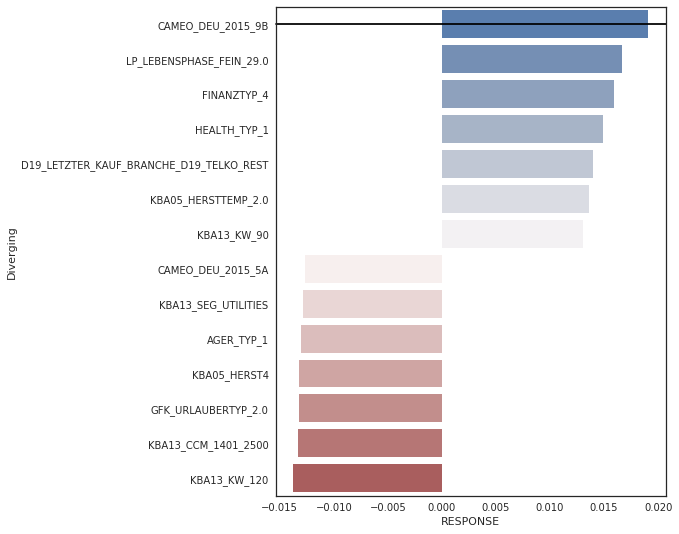

In [72]:
# Center the data to make it diverging
f, (ax2) = plt.subplots(1, 1, figsize=(7, 9), sharex=True)
sns.barplot(x=sub_response_corr, y=sub_response_corr.index, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Diverging")

### 2.5 Model training

#### 2.5.1 Create estimator

Obtain objects needed for the training

In [73]:

session = sagemaker.Session()
prefix = 'mailout-xgboost'


container = get_image_uri(session.boto_region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


In [74]:
s3_output_location = 's3://{}/{}/output'.format(session.default_bucket(),prefix)
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.large',
                                    train_volume_size = 1,
                                    output_path=s3_output_location,
                                    sagemaker_session=sagemaker.Session())

#### 2.5.2 Hyperparameter tuning

In [75]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

Create the hyperparameter tuner object

In [76]:
hyperparameter_ranges = {'max_depth': IntegerParameter(2,8),
                         'eta': ContinuousParameter(0.1, 0.5),
                         'min_child_weight' : IntegerParameter(3,9),
                         'num_round': IntegerParameter(6, 12),
                         'gamma': IntegerParameter(2,6),
                         'subsample': ContinuousParameter(0.5, 1.0)}

objective_metric_name = 'validation:auc'

xgb_hyperparameter_tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=9,
                            max_parallel_jobs=3)

#### 2.5.3 Fit the model

In [77]:
X = mailout_train_df
y = mailout_train_df_target

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.15, random_state=42)

In [78]:
data_dir = '../data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1).to_csv(os.path.join(data_dir, 'mailout_train.csv'), header=None, index=None)

pd.concat([pd.DataFrame(val_y), pd.DataFrame(val_X)], axis=1).to_csv(os.path.join(data_dir, 'mailout_validation.csv'), header=None, index=None)


In [79]:
train_location = session.upload_data(os.path.join(data_dir, 'mailout_train.csv'),key_prefix=prefix)
validation_location = session.upload_data(os.path.join(data_dir, 'mailout_validation.csv'),key_prefix=prefix)

In [80]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='csv')

In [81]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.wait()


#xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

.............................................................................................................................!


Create a new estimator object attached to the best training job found during hyperparameter tuning

In [82]:
xgb_attached = xgb.attach(xgb_hyperparameter_tuner.best_training_job())

2020-05-14 19:34:52 Starting - Preparing the instances for training
2020-05-14 19:34:52 Downloading - Downloading input data
2020-05-14 19:34:52 Training - Training image download completed. Training in progress.
2020-05-14 19:34:52 Uploading - Uploading generated training model
2020-05-14 19:34:52 Completed - Training job completedArguments: train
[2020-05-14:19:34:35:INFO] Running standalone xgboost training.
[2020-05-14:19:34:35:INFO] Setting up HPO optimized metric to be : auc
[2020-05-14:19:34:35:INFO] File size need to be processed in the node: 83.34mb. Available memory size in the node: 197.69mb
[2020-05-14:19:34:35:INFO] Determined delimiter of CSV input is ','
[19:34:35] S3DistributionType set as FullyReplicated
[19:34:35] 38408x567 matrix with 21762134 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-05-14:19:34:35:INFO] Determined delimiter of CSV input is ','
[19:34:35] S3DistributionType set as FullyReplicated
[19:34:36] 9622x567 mat

In [83]:
xgb_transformer = xgb_attached.transformer(instance_count=1, 
                                           instance_type='ml.m5.large',
                                           output_path='s3://{}/mailout/transform/test'.format(bucket_name))

In [84]:
mailout_test_df.to_csv(os.path.join(data_dir, 'mailout_test.csv'), header=None, index=None)
test_location = session.upload_data(os.path.join(data_dir, 'mailout_test.csv'),key_prefix=prefix)

In [85]:
xgb_transformer.transform(data=test_location, data_type='S3Prefix', content_type='text/csv', split_type='Line')
xgb_transformer.wait()

.................Arguments: serve
[2020-05-14 19:45:26 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-05-14 19:45:26 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-05-14 19:45:26 +0000] [1] [INFO] Using worker: gevent
[2020-05-14 19:45:26 +0000] [35] [INFO] Booting worker with pid: 35
[2020-05-14 19:45:27 +0000] [36] [INFO] Booting worker with pid: 36
[2020-05-14:19:45:27:INFO] Model loaded successfully for worker : 36
[2020-05-14:19:45:27:INFO] Model loaded successfully for worker : 35
[2020-05-14:19:45:47:INFO] Sniff delimiter as ','
[2020-05-14:19:45:47:INFO] Determined delimiter of CSV input is ','
[2020-05-14:19:45:47:INFO] Sniff delimiter as ','
[2020-05-14:19:45:47:INFO] Determined delimiter of CSV input is ','
[2020-05-14:19:45:47:INFO] Sniff delimiter as ','
[2020-05-14:19:45:47:INFO] Determined delimiter of CSV input is ','
[2020-05-14:19:45:47:INFO] Sniff delimiter as ','
[2020-05-14:19:45:47:INFO] Determined delimiter of CSV input is ','
2020-05-14T19:45:44

In [86]:
s3file_uri = 's3://'+bucket_name+'/mailout/transform/test/mailout_test.csv.out'
!aws s3 cp  $s3file_uri ./

download: s3://sagemaker-eu-west-1-848439228145/mailout/transform/test/mailout_test.csv.out to ./mailout_test.csv.out


In [87]:
#mailout_test_response = pd.DataFrame()
filename = "mailout_test.csv.out"

mailout_test_response = pd.read_csv(filename, header = None, names = ['Response'])
mailout_test_response.head()

,Response
0,0.117432
1,0.117432
2,0.117432
3,0.117432
4,0.117432


In [88]:
mailout_test_response['LNR'] = LNR_test
mailout_test_response.head()

,Response,LNR
0,0.117432,1754
1,0.117432,1770
2,0.117432,1465
3,0.117432,1470
4,0.117432,1478


In [89]:
mailout_test_response.to_csv("Submission.csv", header = True, index = None)